In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import cv2

from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [3]:
#manual f1_score implementation

from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model = load_model("Best_model_frozen_f1.h5", custom_objects={"f1" : f1})

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 360, 360, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 360, 360, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 12, 12, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [4]:
model.get_layer("resnet50v2").summary()
print("hi")

NameError: name 'model' is not defined

In [26]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_6 [(None, 360, 360, 3)] True
1 tf.math.truediv_1 (None, 360, 360, 3) True
2 tf.math.subtract_1 (None, 360, 360, 3) True
3 resnet50v2 (None, 12, 12, 2048) True
4 global_average_pooling2d_1 (None, 2048) True
5 dropout_1 (None, 2048) True
6 dense_1 (None, 8) True


In [5]:
# read in dataframe with image data and extras
df = pd.read_pickle("F:\Data for Programming\even_classes.pkl")

In [6]:
# check for useless columns that have no variance and drop em
to_drop = []

for col in df.columns:
    if isinstance(df[col][0],np.ndarray):
        print("--------------------------------------")
    else:
        print(f"{col.capitalize()} has {len(df[col].unique())} different values.")
        if len(df[col].unique()) == 1:
            to_drop.append(col)
        
df = df.drop(to_drop, axis=1)
df.info()

Name has 12784 different values.
--------------------------------------
Origin has 3 different values.
Label has 8 different values.
Dim has 114 different values.
Height has 29 different values.
Width has 33 different values.
Channels has 1 different values.
Datatype has 1 different values.
--------------------------------------
Img_lum has 12758 different values.
Img_bright has 12764 different values.
N_black_pix has 39 different values.
--------------------------------------
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12784 entries, 18838 to 34704
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         12784 non-null  object 
 1   img_data     12784 non-null  object 
 2   origin       12784 non-null  object 
 3   label        12784 non-null  object 
 4   dim          12784 non-null  object 
 5   height       12784 non-null  int64  
 6   width        12784 non-nu

In [7]:
#get image and numerical data
img_data = df.img_data
num_data = df[["img_lum", "img_bright", "n_black_pix"]]

# turn target variable into numerical
encoder = LabelEncoder()
target = encoder.fit_transform(df.label)
target = to_categorical(target)

In [8]:
#shuffle the data
print("Before shuffle: ",img_data.shape, num_data.shape, target.shape)
img_data, num_data, target = shuffle(img_data, num_data, target)
print("After shuffle: ",img_data.shape, num_data.shape, target.shape)

Before shuffle:  (12784,) (12784, 3) (12784, 8)
After shuffle:  (12784,) (12784, 3) (12784, 8)


In [9]:
# manual split into train, val and test
train_size = 8000
test_size = 10000

X_train_img, X_train_num, y_train_target = img_data[:train_size], num_data[:train_size], target[:train_size]
X_val_img, X_val_num, y_val_target = img_data[train_size:test_size], num_data[train_size:test_size], target[train_size:test_size]
X_test_img, X_test_num, y_test_target = img_data[test_size:], num_data[test_size:], target[test_size:]

# gotta stack them 
X_train_img = np.stack(X_train_img, axis=0)
X_val_img = np.stack(X_val_img, axis=0)
X_test_img = np.stack(X_test_img, axis=0)

print(f"Train sizes: {X_train_img.shape, X_train_num.shape, y_train_target.shape}")
print(f"Val sizes: {X_val_img.shape, X_val_num.shape, y_val_target.shape}")
print(f"Test sizes: {X_test_img.shape, X_test_num.shape, y_test_target.shape}")

Train sizes: ((8000, 360, 360, 3), (8000, 3), (8000, 8))
Val sizes: ((2000, 360, 360, 3), (2000, 3), (2000, 8))
Test sizes: ((2784, 360, 360, 3), (2784, 3), (2784, 8))


In [10]:
#normalize layer
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train_num)

# augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.CenterCrop(360,360)])

In [13]:
def create_mixed_model(n_labels, fine_tuning="none"):
    
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(360, 360, 3))

    input_img = Input(shape=(360, 360, 3))
    rescale = tf.keras.applications.resnet_v2.preprocess_input(input_img)
    augmented = data_augmentation(rescale)
    resnet = base_model(augmented)
    pooling = layers.GlobalAveragePooling2D()(resnet)
    flatten = Flatten()(pooling)
    #dropout = layers.Dropout(0.4)(pooling)
    hidden1 = Dense(256, activation="tanh")(flatten)
    output_img = Dense(n_labels, activation="softmax")(hidden1)
    model_img = Model(inputs=input_img, outputs=output_img)
    
    
    input_num = Input(shape=(3,))
    normal = normalizer(input_num)
    hidden2 = Dense(16, activation="relu")(normal)
    output_num = Dense(n_labels, activation="softmax")(hidden2) # maybe change to softmax
    model_num = Model(inputs=input_num, outputs=output_num)
    
    combined = layers.concatenate([model_img.output, model_num.output])
    
    final = Dense(256, activation="relu")(combined)
    x = Dense(8, activation="softmax")(final)
    
    model = Model(inputs=[model_img.inputs, model_num.inputs], outputs=x)
    
    #with fine tuning
    if isinstance(fine_tuning, int):
        for layer in base_model.layers[:fine_tuning]:
            layer.trainable = False
        for layer in base_model.layers[fine_tuning:]:
            layer.trainable = True
        optimizer = Adam(learning_rate=.0001)
        
    else:
        for layer in base_model.layers:
            layer.trainable = False
        optimizer = Adam(learning_rate=.001)
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=[f1])
    
    return model

In [14]:
# create the model through the function, print summary and add callbacks
model_no_ft = create_mixed_model(n_labels=8)

#callback function to reduce learning rate when needed
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='f1', factor=0.8,
                                                 patience=3, min_lr=1e-5, verbose=1)

#another callback function to stop when no improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=5)

filepath = os.path.join(os.getcwd(), "model_checkpoint")
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_loss",
                             verbose=1, 
                             save_best_only=True,
                             mode="min")


history = model_no_ft.fit(x=[X_train_img, X_train_num], y=y_train_target,
                          epochs = 15, 
                          validation_data=([X_val_img, X_val_num],y_val_target), 
                          callbacks=[reduce_lr, early_stop, checkpoint])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 360, 360, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 360, 360, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 sequential (Sequential)        (None, 360, 360, 3)  0           ['tf.math.subtract[0][0]'] 

INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 2412s 10s/step - loss: 1.7740 - f1: 0.0185 - val_loss: 1.3998 - val_f1: 0.1966 - lr: 0.0010
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 1.1610 - f1: 0.3994
Epoch 2: val_loss improved from 1.39983 to 1.01839, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 2277s 9s/step - loss: 1.1610 - f1: 0.3994 - val_loss: 1.0184 - val_f1: 0.4512 - lr: 0.0010
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.9333 - f1: 0.4771
Epoch 3: val_loss improved from 1.01839 to 0.90346, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 2232s 9s/step - loss: 0.9333 - f1: 0.4771 - val_loss: 0.9035 - val_f1: 0.4770 - lr: 0.0010
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.8488 - f1: 0.4966 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 4: val_loss did not improve from 0.90346
250/250 [==============================] - 3535s 14s/step - loss: 0.8488 - f1: 0.4966 - val_loss: 0.9294 - val_f1: 0.4785 - lr: 0.0010
Epoch 5/15
250/250 [==============================] - ETA: 0s - loss: 0.7500 - f1: 0.5900 
Epoch 5: val_loss improved from 0.90346 to 0.77160, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 3527s 14s/step - loss: 0.7500 - f1: 0.5900 - val_loss: 0.7716 - val_f1: 0.6288 - lr: 8.0000e-04
Epoch 6/15
250/250 [==============================] - ETA: 0s - loss: 0.6605 - f1: 0.6986 
Epoch 6: val_loss improved from 0.77160 to 0.72095, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 3403s 14s/step - loss: 0.6605 - f1: 0.6986 - val_loss: 0.7210 - val_f1: 0.6995 - lr: 8.0000e-04
Epoch 7/15
250/250 [==============================] - ETA: 0s - loss: 0.5818 - f1: 0.7618 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 7: val_loss improved from 0.72095 to 0.60284, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 3199s 13s/step - loss: 0.5818 - f1: 0.7618 - val_loss: 0.6028 - val_f1: 0.7633 - lr: 8.0000e-04
Epoch 8/15
250/250 [==============================] - ETA: 0s - loss: 0.5182 - f1: 0.8007 
Epoch 8: val_loss improved from 0.60284 to 0.55899, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 4060s 16s/step - loss: 0.5182 - f1: 0.8007 - val_loss: 0.5590 - val_f1: 0.8014 - lr: 6.4000e-04
Epoch 9/15
250/250 [==============================] - ETA: 0s - loss: 0.4834 - f1: 0.8287 
Epoch 9: val_loss improved from 0.55899 to 0.54316, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 3825s 15s/step - loss: 0.4834 - f1: 0.8287 - val_loss: 0.5432 - val_f1: 0.8273 - lr: 6.4000e-04
Epoch 10/15
250/250 [==============================] - ETA: 0s - loss: 0.4435 - f1: 0.8504 
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 10: val_loss improved from 0.54316 to 0.50236, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 4057s 16s/step - loss: 0.4435 - f1: 0.8504 - val_loss: 0.5024 - val_f1: 0.8391 - lr: 6.4000e-04
Epoch 11/15
250/250 [==============================] - ETA: 0s - loss: 0.3998 - f1: 0.8715 
Epoch 11: val_loss improved from 0.50236 to 0.49132, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 4696s 19s/step - loss: 0.3998 - f1: 0.8715 - val_loss: 0.4913 - val_f1: 0.8424 - lr: 5.1200e-04
Epoch 12/15
250/250 [==============================] - ETA: 0s - loss: 0.3637 - f1: 0.8883 
Epoch 12: val_loss did not improve from 0.49132
250/250 [==============================] - 10164s 41s/step - loss: 0.3637 - f1: 0.8883 - val_loss: 0.5003 - val_f1: 0.8480 - lr: 5.1200e-04
Epoch 13/15
250/250 [==============================] - ETA: 0s - loss: 0.3490 - f1: 0.8884 
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 13: val_loss improved from 0.49132 to 0.42607, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 5894s 24s/step - loss: 0.3490 - f1: 0.8884 - val_loss: 0.4261 - val_f1: 0.8675 - lr: 5.1200e-04
Epoch 14/15
250/250 [==============================] - ETA: 0s - loss: 0.3219 - f1: 0.9031 
Epoch 14: val_loss improved from 0.42607 to 0.42415, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


250/250 [==============================] - 4024s 16s/step - loss: 0.3219 - f1: 0.9031 - val_loss: 0.4241 - val_f1: 0.8710 - lr: 4.0960e-04
Epoch 15/15
250/250 [==============================] - ETA: 0s - loss: 0.3038 - f1: 0.9060 
Epoch 15: val_loss improved from 0.42415 to 0.41548, saving model to C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\ezitt\Jupyter stuff\DataScientest Projekt\model_checkpoint\assets



250/250 [==============================] - 4016s 16s/step - loss: 0.3038 - f1: 0.9060 - val_loss: 0.4155 - val_f1: 0.8760 - lr: 4.0960e-04


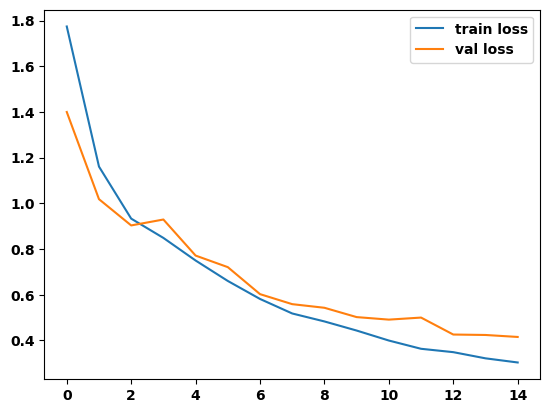

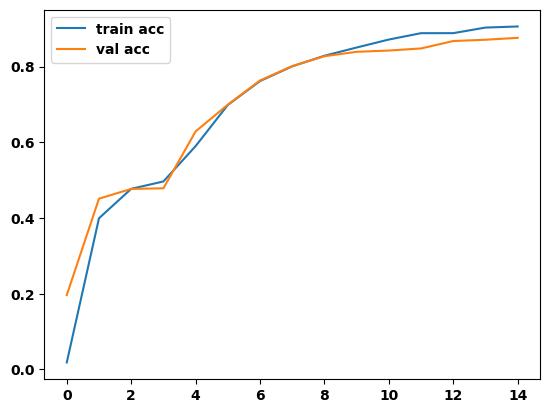

In [15]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossValLoss_f1_mixed_input.png')
plt.show()

# plot the accuracy
plt.plot(history.history['f1'], label='train acc')
plt.plot(history.history['val_f1'], label='val acc')
plt.legend()
plt.savefig('f1_acc_mixed_input.png')
plt.show()

In [16]:
# evaluate the model with test_generator
score = model_no_ft.evaluate(x=[X_test_img, X_test_num], y=y_test_target)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

87/87 [==============================] - 1045s 12s/step - loss: 0.4052 - f1: 0.8694
Test loss: 0.4051550626754761
Test accuracy: 0.8693840503692627


In [17]:
# compare predicted and actual classes
from sklearn.metrics import accuracy_score, f1_score

predicted = model_no_ft.predict([X_test_img, X_test_num])                        # predicted values or probabilities?
predicted_classes = np.argmax(predicted, axis=-1)        # predicted classes

true_classes = np.argmax(y_test_target, axis=-1)                # equal to y_test

acc_score = accuracy_score(true_classes, predicted_classes)
f1_score = f1_score(true_classes, predicted_classes, average="weighted")
print(f"Mixed_input Model Accuracy without Fine-Tuning: {round(acc_score * 100, 2)}")
print(f"Mixed_input Model F1 Score without Fine-Tuning: {round(f1_score * 100, 2)}")

87/87 [==============================] - 1038s 12s/step
Mixed_input Model Accuracy without Fine-Tuning: 87.07
Mixed_input Model F1 Score without Fine-Tuning: 87.1


In [18]:
# get the layer index from where we want to fine tune
layer_name = model_no_ft.get_layer("resnet50v2").get_layer("conv5_block1_preact_bn")
layer_index = model_no_ft.get_layer("resnet50v2").layers.index(layer_name)
layer_index

In [ ]:
# time to fine tune the previous model by unfreezing the last (5th) block of the base model resnet
model_ft = create_model(n_classes=8, fine_tuning=layer_index)

history_ft_mixed = model_no_ft.fit(x=[X_train_img, X_train_num], y=y_train_target,
                          epochs = 15, 
                          validation_data=([X_val_img, X_val_num],y_val_target), 
                          callbacks=[reduce_lr, early_stop, checkpoint])